In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

评价函数模块 `_criterion.*` 详解
=================================

### 0. 大纲

本文会按照类的继承关系，由上到下介绍各个类的成员及实现细节，尽量说得详细点。

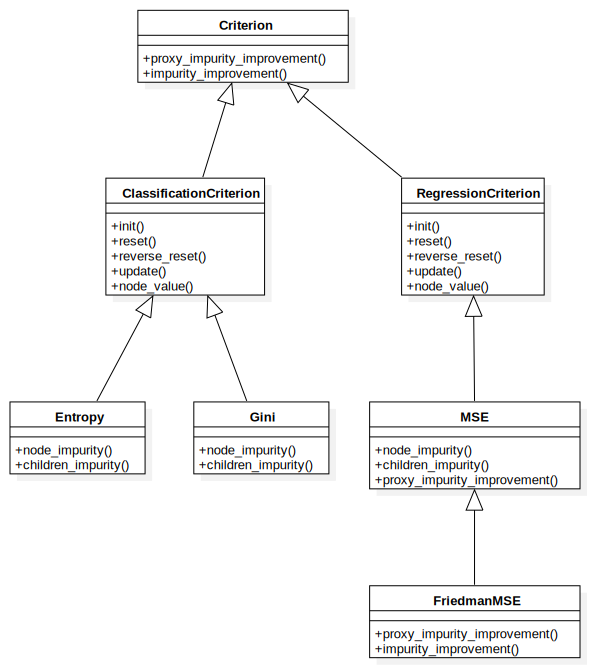

In [17]:
SVG("./res/uml/Model___criterion_1.svg")

### 1. Criterion, 接口类
Criterion 作为接口之用，相当于 Java 中的抽象类。其接口定义在 `_criterion.pxd` 文件，实现在 `_criterion.pyx` 中。

我们对 Criterion 分为两部份来说明：内部成员，和函数方法。

##### 1.0 内部成员
为了计算和存储效率，sklearn 做了些针对性的数据设计。当然，其实思路挺直觉的，我们带着具体的成员变量来说明。

+ 数据分条 (stride)

  二维数组会用一维数组（其实是个连续的缓存）加上偏移量来实现，我以前在数字图像处理中常看到。      
  
  ```Python
     26     # Internal structures
     27     cdef DOUBLE_t* y                     # Values of y
     28     cdef SIZE_t y_stride                 # Stride in y (since n_outputs >= 1)
     29     cdef DOUBLE_t* sample_weight         # Sample weights
  ```

  分类的标签或者回归的值（$y$）可能是个向量，所以需要对 $y$ 值分条，每条的长度自然是 `y_stride`。     
  `sample_weight` 是各个样本的权重值，不用多讲。

+ 使用索引

  决策树分割节点时会涉及到移动样本，因为 $x$ 通常维数较多，开销较大。对于这类问题，一个常见的做法就是交换索引，而不变动值。具体到数组操组，这个索引就是下标值。
  
  ```Python
  31     cdef SIZE_t* samples                 # Sample indices in X, y
  32     cdef SIZE_t start                    # samples[start:pos] are the samples in the left node
  33     cdef SIZE_t pos                      # samples[pos:end] are the samples in the right node
  34     cdef SIZE_t end
  ```
  
  这里样本值的索引区间其实是前闭后开，即 samples[start:pos) 和 samples[pos:end)。

+ 加权处理

  加权的样本数目统计
  ```Python
  36     cdef SIZE_t n_outputs                # Number of outputs
  37     cdef SIZE_t n_node_samples           # Number of samples in the node (end-start)
  38     cdef double weighted_n_samples       # Weighted number of samples (in total)
  39     cdef double weighted_n_node_samples  # Weighted number of samples in the node
  40     cdef double weighted_n_left          # Weighted number of samples in the left node
  41     cdef double weighted_n_right         # Weighted number of samples in the right node
  ```
  
  加权的 $y$ 值累加和（若是分类，则是对各个类别单独做累加）
  ```Python
  43     cdef double* sum_total          # For classification criteria, the sum of the
  44                                     # weighted count of each label. For regression,
  45                                     # the sum of w*y. sum_total[k] is equal to
  46                                     # sum_{i=start}^{end-1} w[samples[i]]*y[samples[i], k],
  47                                     # where k is output index.
  48     cdef double* sum_left           # Same as above, but for the left side of the split
  49     cdef double* sum_right          # same as above, but for the right side of the split
  ```

##### 1.1 函数方法
+ 纯接口

```Python
 54     # Methods
 55     cdef void init(self, DOUBLE_t* y, SIZE_t y_stride, DOUBLE_t* sample_weight,
 56                    double weighted_n_samples, SIZE_t* samples, SIZE_t start,
 57                    SIZE_t end) nogil
 58     cdef void reset(self) nogil
 59     cdef void reverse_reset(self) nogil
 60     cdef void update(self, SIZE_t new_pos) nogil
 61     cdef double node_impurity(self) nogil
 62     cdef void children_impurity(self, double* impurity_left,
 63                                 double* impurity_right) nogil
 64     cdef void node_value(self, double* dest) nogil
```

+ 计算不纯度提升量

```Python
 65     cdef double impurity_improvement(self, double impurity) nogil
 66     cdef double proxy_impurity_improvement(self) nogil
```

`proxy_impurity_improvement`：

\begin{align}
    & \frac{N_t}{N} \left ( \text{ impurity } - \frac{N_{t,R}}{N_t} \text{ right_impurity } - \frac{N_{t,L}}{N_t} \text{ left_impurity } \right ) \\
    &= \frac{N_t}{N} \text{ impurity } - \frac{N_{t,R}}{N} \text{ right_impurity } - \frac{N_{t,L}}{N} \text{ left_impurity } \\
    &= \frac{N_t}{N} \text{ impurity } - \frac{1}{N} \underbrace{ \left ( N_{t,R} \text{ right_impurity } - N_{t,L} \text{ left_impurity } \right ) }_{\text{impurity_improvement}} \\
\end{align}

对一个节点，去除公式中的常量，弄了个 `impurity_improvement` 来减少计算量。

### 2. 分类评价函数

#### 2.0 ClassificationCriterion
ClassificationCriterion 类是分类评估函数的父类，主要𫐄实现初始化和一些预处理函数。我们从上到下依序看代码。

##### 2.0.0 变量

```Python
 207 cdef class ClassificationCriterion(Criterion):
 208     """Abstract criterion for classification."""
 209
 210     cdef SIZE_t* n_classes
 211     cdef SIZE_t sum_stride
```

这里分类为了支持多输出（target）问题，用 `n_classes` 来统计每个输出的类别个数，用 `sum_stride` 来对齐不同输出的结果。用文字表述比较困难，下面的图说明更清晰点。

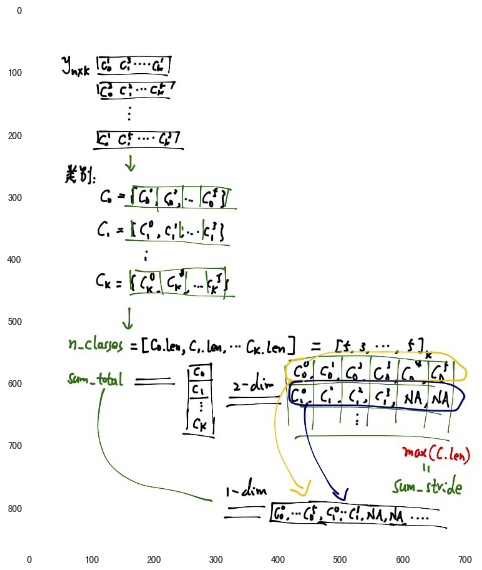

In [18]:
show_image("./res/ClassificationCriterion.jpg", figsize=(8,15))

##### 2.0.1 `__cinit__`
接下来，我们看构造函数：

```Python
 213     def __cinit__(self, SIZE_t n_outputs,
 214                   np.ndarray[SIZE_t, ndim=1] n_classes):
 215         """Initialize attributes for this criterion.
 216 +--  7 lines: Parameters---------------------------------------------------------
 223         """
 224
 225 #+-- 20 lines: self.y = NULL------------------------------------------------------
 245
 246         safe_realloc(&self.n_classes, n_outputs)
 247 #+--  6 lines: cdef SIZE_t k = 0--------------------------------------------------
 253         for k in range(n_outputs):
 254             self.n_classes[k] = n_classes[k]
 255
 256             if n_classes[k] > sum_stride:
 257                 sum_stride = n_classes[k]
 258
 259         self.sum_stride = sum_stride
 260
 261         cdef SIZE_t n_elements = n_outputs * sum_stride
 262         self.sum_total = <double*> calloc(n_elements, sizeof(double))
 263 #+--  7 lines: self.sum_left = <double*> calloc(n_elements, sizeof(double))-------
``` 

主要是三个工作：

+ 初始化变量，设置默认值。
+ 复制 `n_classes`，同时记录最大值 `sum_stride` 用于对齐。
+ 为 `sum_*` 统计各类别信息的变量申请空间。

##### 2.0.2 `init`
应该是为了重复使用，这里单独写了初始化函数。

```Python
 282     cdef void init(self, DOUBLE_t* y, SIZE_t y_stride,
 283                    DOUBLE_t* sample_weight, double weighted_n_samples,
 284                    SIZE_t* samples, SIZE_t start, SIZE_t end) nogil:
 285         """Initialize the criterion at node samples[start:end] and
 286 +-- 19 lines: children samples[start:start] and samples[start:end].--------------
 305         """
 306
 307 #+-- 19 lines: self.y = y---------------------------------------------------------
 326
 327         for k in range(self.n_outputs):
 328             memset(sum_total + offset, 0, n_classes[k] * sizeof(double))
 329             offset += self.sum_stride
 330
 331         for p in range(start, end):
 332             i = samples[p]
 333 #+--  4 lines: w is originally set to be 1.0, meaning that if no sample weights---
 337                 w = sample_weight[i]
 338
 339             # Count weighted class frequency for each target
 340             for k in range(self.n_outputs):
 341                 c = <SIZE_t> y[i * y_stride + k]
 342                 sum_total[k * self.sum_stride + c] += w
 343
 344             self.weighted_n_node_samples += w
 345
 346         # Reset to pos=start
 347         self.reset()
```

主要流程是：

+ 307L-326L, 复制参数和设置默认值；
+ 327L-330L, 清零 `sum_total`。     
  注意 328L 的优化， `memset` 最后一个参数是各输出的实际类别数，所以只会清实际用到的空间。
+ 331L-344L, 统计各类别的权重值 `sum_total` 和总权重值 `weighted_n_node_samples`。     
  其中，340L 取到输出 $k$, 341L 取到类别 $c$，累加相应的总值 $\text{sum_total}[k, c]$。

##### 2.0.3 `reset`
reset 方法正如其名，做了重置工作，将节点位置 `pos` 恢复到最左边 `start` 位置，并更新统计信息。

```Python
 349     cdef void reset(self) nogil:                                                  350         """Reset the criterion at pos=start."""
 351
 352         self.pos = self.start
 353
 354         self.weighted_n_left = 0.0
 355         self.weighted_n_right = self.weighted_n_node_samples
 356
 357 #+--  7 lines: cdef double* sum_total = self.sum_total----------------------------
 364         for k in range(self.n_outputs):
 365             memset(sum_left, 0, n_classes[k] * sizeof(double))
 366             memcpy(sum_right, sum_total, n_classes[k] * sizeof(double))
 367
 368             sum_total += self.sum_stride
 369 #+---  2 lines: sum_left += self.sum_stride---------------------------------------
```

主要工作，清掉左节点的信息，覆盖右节点。

`reverse_reset` 和 `reset` 操作互反，不赘述。

##### 2.0.4 `update`
update 函数将节点移到指定位置，并更新统计信息。

```Python
 394     cdef void update(self, SIZE_t new_pos) nogil:
 395         """Updated statistics by moving samples[pos:new_pos] to the left child.
 396 +--  6 lines: Parameters---------------------------------------------------------
 402         """
 403         cdef DOUBLE_t* y = self.y
 404 #+-- 17 lines: cdef SIZE_t pos = self.pos-----------------------------------------
 421
 422 #+--  8 lines: Update statistics up to new_pos------------------------------------
 430         if (new_pos - pos) <= (end - new_pos):
 431             for p in range(pos, new_pos):
 432 #+--  8 lines: i = samples[p]-----------------------------------------------------
 440                     sum_left[label_index] += w
 441
 442                 self.weighted_n_left += w
 443
 444         else:
 445             self.reverse_reset()
 446
 447             for p in range(end - 1, new_pos - 1, -1):
 448 #+--  8 lines: i = samples[p]-----------------------------------------------------
 456                     sum_left[label_index] -= w
 457
 458                 self.weighted_n_left -= w
 459
 460         # Update right part statistics
 461         self.weighted_n_right = self.weighted_n_node_samples - self.weighted_n_le     ft
 462         for k in range(self.n_outputs):
 463             for c in range(n_classes[k]):
 464                 sum_right[c] = sum_total[c] - sum_left[c]
 465 #+--  4 lines: sum_right += self.sum_stride---------------------------------------
 469
 470         self.pos = new_pos 
```

主要流程如下：

+ 初始化参数；
+ 422L-458L, 更新左节点的统计信息。      
  这里的优化，是判断指定位置、当前节点和最右边三者的距离，遍历较小的距离。
+ 460L-465L, 更新右节点的统计信息：$\text{sum_right } = \text{ sum_total } - \text{ sum_left }$。 

##### 2.0.5 `node_value`
作用是将 `sum_total` 的数据拷贝出来，不多说。

```Python
 479     cdef void node_value(self, double* dest) nogil:
 480         """Compute the node value of samples[start:end] and save it into dest.
 481 +--  5 lines: Parameters---------------------------------------------------------
 486         """
 487 #+--  4 lines: cdef double* sum_total = self.sum_total----------------------------
 491
 492         for k in range(self.n_outputs):
 493             memcpy(dest, sum_total, n_classes[k] * sizeof(double))
 494 #+--  2 lines: dest += self.sum_stride--------------------------------------------
```

##### 2.0.6 小结
我们可以看出，`ClassificationCriterion` 的主要工作是在更新 `sum_*` 变量。这三个变量的数据是相应节点中各个类的权重值，用这三个变量可以算出各类 $k$ 在节点 $i$ 的权重占比 $p_i^k$。而我们知道，常用的 gini、entropy 和 misclassification_rate 都是基于 $p_i^k$ 来表达。所以，将更新权重信息函数汇总，便于复用，正是此父类的存在意义。

有了 $p_k^i$ 权重占比，再下面的子类就纯粹是数学计算了，加上这几个式子都简单，代码非常清晰。需要注意，对多输出的问题，评价值是统一加合取平均。

#### 2.1 Entropy

 $\text{cross-entropy  } = -\sum_{k=0}^{K-1} \text{ count_k } \log( \text{ count_k }) $

```Python
 498 cdef class Entropy(ClassificationCriterion):
 499     """Cross Entropy impurity criterion.
 500 +-- 11 lines: This handles cases where the target is a classification taking valu
 511         cross-entropy = -\sum_{k=0}^{K-1} count_k log(count_k)
 512     """
 513
 514     cdef double node_impurity(self) nogil:
 515 #+-- 10 lines: """Evaluate the impurity of the current node, i.e. the impurity of-
 525         for k in range(self.n_outputs):
 526             for c in range(n_classes[k]):
 527                 count_k = sum_total[c]
 528                 if count_k > 0.0:
 529                     count_k /= self.weighted_n_node_samples
 530                     entropy -= count_k * log(count_k)
 531 #+--  3 lines: sum_total += self.sum_stride---------------------------------------
 534         return entropy / self.n_outputs
 535
 536     cdef void children_impurity(self, double* impurity_left,
 537                                 double* impurity_right) nogil:
 538 #+-- 22 lines: """Evaluate the impurity in children nodes-------------------------
 560         for k in range(self.n_outputs):
 561             for c in range(n_classes[k]):
 562                 count_k = sum_left[c]
 563                 if count_k > 0.0:
 564                     count_k /= self.weighted_n_left
 565                     entropy_left -= count_k * log(count_k)
 566
 567                 count_k = sum_right[c]
 568                 if count_k > 0.0:
 569                     count_k /= self.weighted_n_right
 570                     entropy_right -= count_k * log(count_k)
 571 #+--  3 lines: sum_left += self.sum_stride----------------------------------------
 574
 575         impurity_left[0] = entropy_left / self.n_outputs
 576         impurity_right[0] = entropy_right / self.n_outputs
```

#### 2.2 Gini
$ \text{ index } = 1 - \sum_{k=0}^{K-1} \text{ count_k}^2 $

```Python
 579 cdef class Gini(ClassificationCriterion):
 580     """Gini Index impurity criterion.
 581 +-- 11 lines: This handles cases where the target is a classification taking valu
 592         index = \sum_{k=0}^{K-1} count_k (1 - count_k)
 593               = 1 - \sum_{k=0}^{K-1} count_k ** 2
 594     """
 595
 596     cdef double node_impurity(self) nogil:
 597 #+-- 12 lines: """Evaluate the impurity of the current node, i.e. the impurity of-
 609         for k in range(self.n_outputs):
 610             sq_count = 0.0
 611
 612             for c in range(n_classes[k]):
 613                 count_k = sum_total[c]
 614                 sq_count += count_k * count_k
 615
 616             gini += 1.0 - sq_count / (self.weighted_n_node_samples *
 617                                       self.weighted_n_node_samples)
 618
 619             sum_total += self.sum_stride
 620
 621         return gini / self.n_outputs
 622
 623     cdef void children_impurity(self, double* impurity_left,
 624                                 double* impurity_right) nogil:
 625         """Evaluate the impurity in children nodes
 626 #+-- 45 lines: i.e. the impurity of the left child (samples[start:pos]) and the---
```

### 3. 回归评价函数

#### 3.0 RegressionCriterion
RegressionCriterion 是回归评价的父类，与分类预计算权重占比 $p_k^i$ 类似，回归会预计算节点的方差值。为了节省计算量，对公式做了变形，降低了计算次数，具体推导如下所示：

\begin{align}
    \text{var } &= \frac{1}{n} \sum_i^n (y_i - \bar{y})^2 \\
                &= E \left [ (y_i - E(y_i))^2 \right ] \\
                &= E[y_i^2] - E^2[y_i] \\
                &= \frac{1}{n} \sum_i^n (y_i^2) - \bar{y}^2 \\
                &= \frac{1}{n} \sum_i^n (y_i^2) - \left ( \frac{1}{n} \sum_i^n y_i \right )^2 \\
                & \text{ 引入权重值 } \\
                &= \sum_i^n ( w_i (y_i^2) ) / \sum_i^n w_i - \left ( \sum_i^n (w_i y_i) / \sum_i^n w_i \right )^2 \\
                &= \frac{\text{sq_sum_total}}{\text{weighted_n_node_samples}} - \left (\frac{\text{sum_total}}{\text{weighted_n_node_samples}} \right )^2
\end{align}

所以，RegressionCriterion 的方法都是在计算和更新上述式子中的三个变量（还有子节点的），因为整个代码和分类相似，不再赘述。

##### 3.1 MSE
其实这里 MSE 用的公式就是上述的方差公式。虽然实际实义中 $\text{MSE } = E [ y_i - \hat{y}_i ]$，但因为决策树预测值用的是均值，所以全部 $\hat{y}_i = \bar{y_i}$，于是退化成了计算方差的公式。

##### 3.2 FriedmanMSE
FriedmanMSE 来源于 Friedman 论文 [Greedy Function Approximation: A Gradient Boosting Machine(https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) 中的公式 (35)，跟 Gradient Boosting 相关，这方面我还没看，等后继写到 GBDT 时再回来补上。

### 总结

本文较为详细地介绍了 sklearn 中评估函数模块的实现细节：一个接口类，两个辅助计算的父类，四个具体计算的子类。